In [0]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [19]:
# reading data
df = pd.read_excel('dataset.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['class'])))

Shape of dataset  (100, 2)
Index(['message', 'class'], dtype='object')
No. of unique classes 17


In [0]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [21]:
texts = []
labels = []


for idx in range(df.message.shape[0]):
    text = BeautifulSoup(df.message[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['class']:
    labels.append(idx)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 932


In [23]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Shape of Data Tensor: (100, 1000)
Shape of Label Tensor: (100, 17)


In [24]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         93300     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 17)                3417      
Total params: 257,517
Trainable params: 257,517
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Train on 80 samples, validate on 20 samples
Epoch 1/15
80/80 [==============================] - 168s 2s/step - loss: 2.4410 - acc: 0.2125 - val_loss: 1.9150 - val_acc: 0.4500

Epoch 00001: val_acc improved from -inf to 0.45000, saving model to model_rnn.hdf5
Epoch 2/15
80/80 [==============================] - 147s 2s/step - loss: 2.0052 - acc: 0.4750 - val_loss: 1.5308 - val_acc: 0.5500

Epoch 00002: val_acc improved from 0.45000 to 0.55000, saving model to model_rnn.hdf5
Epoch 3/15
80/80 [==============================] - 140s 2s/step - loss: 1.5564 - acc: 0.5750 - val_loss: 1.3702 - val_acc: 0.6500

Epoch 00003: val_acc improved from 0.55000 to 0.65000, saving model to model_rnn.hdf5
Epoch 4/15
80/80 [==============================] - 99s 1s/step - loss: 1.3451 - acc: 0.6125 - val_loss: 1.1095 - val_acc: 0.6500

Epoch 00004: val_acc did not improve from 0.65000
Epoch 5/15
48/80 [=================>............] - ETA: 28s - loss: 1.1962 - acc: 0.6667

80/80 [==============================] - 76s 944ms/step - loss: 1.1779 - acc: 0.7000 - val_loss: 1.4087 - val_acc: 0.6000

Epoch 00005: val_acc did not improve from 0.65000
Epoch 6/15
80/80 [==============================] - 80s 1s/step - loss: 0.9999 - acc: 0.7250 - val_loss: 0.7506 - val_acc: 0.9000

Epoch 00006: val_acc improved from 0.65000 to 0.90000, saving model to model_rnn.hdf5
Epoch 7/15
80/80 [==============================] - 100s 1s/step - loss: 0.7787 - acc: 0.7875 - val_loss: 0.7046 - val_acc: 0.9500

Epoch 00007: val_acc improved from 0.90000 to 0.95000, saving model to model_rnn.hdf5
Epoch 8/15
80/80 [==============================] - 96s 1s/step - loss: 0.7224 - acc: 0.8000 - val_loss: 0.5418 - val_acc: 0.9500

Epoch 00008: val_acc did not improve from 0.95000
Epoch 9/15
80/80 [==============================] - 136s 2s/step - loss: 0.5805 - acc: 0.8375 - val_loss: 0.5848 - val_acc: 0.9500

Epoch 00009: val_acc did not improve from 0.95000
Epoch 10/15
 4/80 [>.........

80/80 [==============================] - 127s 2s/step - loss: 0.6635 - acc: 0.8250 - val_loss: 0.4901 - val_acc: 0.9500

Epoch 00010: val_acc did not improve from 0.95000
Epoch 11/15
80/80 [==============================] - 103s 1s/step - loss: 0.5786 - acc: 0.8500 - val_loss: 0.4940 - val_acc: 0.9500

Epoch 00011: val_acc did not improve from 0.95000
Epoch 12/15
80/80 [==============================] - 102s 1s/step - loss: 0.4891 - acc: 0.9000 - val_loss: 0.6753 - val_acc: 0.9000

Epoch 00012: val_acc did not improve from 0.95000
Epoch 13/15
80/80 [==============================] - 113s 1s/step - loss: 0.4893 - acc: 0.8875 - val_loss: 0.4899 - val_acc: 0.9500

Epoch 00013: val_acc did not improve from 0.95000
Epoch 14/15
80/80 [==============================] - 104s 1s/step - loss: 0.4824 - acc: 0.8750 - val_loss: 1.1208 - val_acc: 0.6500

Epoch 00014: val_acc did not improve from 0.95000
Epoch 15/15
16/80 [=====>........................] - ETA: 1:26 - loss: 0.6188 - acc: 0.8750

80/80 [==============================] - 111s 1s/step - loss: 0.4562 - acc: 0.8875 - val_loss: 0.4913 - val_acc: 0.9500

Epoch 00015: val_acc did not improve from 0.95000


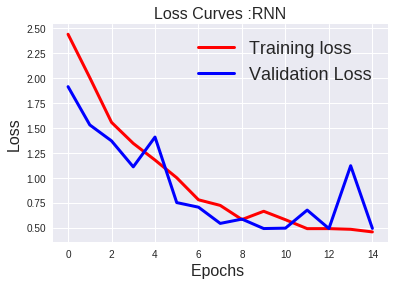

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

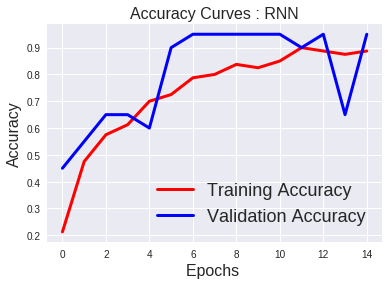

In [21]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()